In [2]:
#NBVAL_IGNORE_OUTPUT
# Adding ignore due to (probably an np notebook magic) bug
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [3]:
from devito import *

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

In [5]:
from examples.seismic import Model, plot_velocity

In [7]:
import numpy as np
import pandas as pd

def capas_pre_devito(vel_original, no_capas, shape_z):
    '''
    Función para calcular la matriz de capas de entrada para hacer el campo de velocidades para devito
    La entrada vel_original debe ser un dataframe con las siguientes columnas ['DEPTH', 'ACOUSTIC_INTERVAL_VEL', 'DELTA_DEPTH']
    no_capas: Las capas que deseo para mi modelo
    Shape_z= la dimención de
    '''
    
    
    depth_max = vel_original['DEPTH'].max()
    intervalo = round(depth_max / (no_capas - 1), 2)
    vel_final= vel_original['ACOUSTIC_INTERVAL_VEL'].iloc[-1]
    
    new_depth = np.arange(0, depth_max, intervalo)
    new_df = pd.DataFrame({'DEPTH': new_depth})
    
    # Interpolación de los valores de velocidad acústica
    new_df['ACOUSTIC_INTERVAL_VEL'] = np.interp(new_df['DEPTH'], vel_original['DEPTH'], vel_original['ACOUSTIC_INTERVAL_VEL'])
    
    # Cálculo de CAPA_INFERIOR
    new_df['CAPA_INFERIOR'] = new_df['DEPTH'] + intervalo / 2
    new_df.iloc[-1, new_df.columns.get_loc('CAPA_INFERIOR')] = new_df['DEPTH'].iloc[-1]
    
    # Cálculo de FILA_INF
    new_df['FILA_INF'] = np.round(new_df['CAPA_INFERIOR'] * (shape_z - 1) / depth_max + 1).astype(int)
    if len(new_df) !=no_capas:
        
        
        last_row = new_df.iloc[-1]
        new_row = pd.DataFrame([last_row], columns=new_df.columns)
        new_row['FILA_INF']=shape_z
        new_row['ACOUSTIC_INTERVAL_VEL']=vel_final
        new_row['DEPTH']=depth_max
        new_row['CAPA_INFERIOR']=depth_max
        new_df = pd.concat([new_df, new_row], ignore_index=True)
        
        
    
    # Creación de las capas con FILA_INF y ACOUSTIC_INTERVAL_VEL
    capas = list(zip(new_df['FILA_INF'], new_df['ACOUSTIC_INTERVAL_VEL'] / 1000))
    
    #return new_df
    return capas


In [8]:
def campo_velocidades_devito(shape, capas):
    """
    Genera un campo de velocidades con un número variable de capas.

    Parameters:
    - shape: Tuple que define la forma de la matriz (número de filas, número de columnas).
    - capas: Lista de tuplas, donde cada tupla contiene dos valores:
             (profundidad_final, velocidad), siendo profundidad_final la columna final de la capa
             y velocidad la velocidad asignada a esa capa.

    Returns:
    - Vel_Devito: Matriz numpy con el campo de velocidades.
    """
    Vel_Devito = np.empty(shape, dtype=np.float32)
    
    # Inicializar el índice inicial en 0
    indice_inicial = 0
    
    for profundidad_final, velocidad in capas:
        Vel_Devito[:, indice_inicial:profundidad_final] = velocidad
        indice_inicial = profundidad_final
    
    return Vel_Devito




In [9]:
def print_registro(model,cant_capas):
    
    #NBVAL_IGNORE_OUTPUT
    from examples.seismic import RickerSource
    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
    src = RickerSource(name='src', grid=model.grid, f0=f0,
                    npoint=1, time_range=time_range)

    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.coordinates.data[0, -1] = 20.  # Depth is 20m

    # We can plot the time signature to see the wavelet
    #src.show()



    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
    src = RickerSource(name='src', grid=model.grid, f0=f0,
                    npoint=1, time_range=time_range)

    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.coordinates.data[0, -1] = 20.  # Depth is 20m


    # We can plot the time signature to see the wavelet
    #src.show()



    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
    src = RickerSource(name='src', grid=model.grid, f0=f0,
                    npoint=1, time_range=time_range)

    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.coordinates.data[0, -1] = 20.  # Depth is 20m

    # We can plot the time signature to see the wavelet
    #src.show()


    #NBVAL_IGNORE_OUTPUT
    from examples.seismic import Receiver

    # Create symbol for 101 receivers
    rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

    # Prescribe even spacing for receivers along the x-axis
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
    rec.coordinates.data[:, 1] = 20.  # Depth is 20m

    # We can now show the source and receivers within our domain:
    # Red dot: Source location
    # Green dots: Receiver locations (every 4th point)
    #plot_velocity(model, source=src.coordinates.data,
    #              receiver=rec.coordinates.data[::4, :])



    from devito import TimeFunction
    # Define the wavefield with the size of the model and the time dimension
    u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

    # We can now write the PDE
    pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

    # The PDE representation is as on paper
    #pde


    # This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
    # Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
    # a time marching updating equation known as a stencil using customized SymPy functions
    from devito import Eq, solve

    stencil = Eq(u.forward, solve(pde, u.forward))
    #stencil



    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

    # Create interpolation expression for receivers
    rec_term = rec.interpolate(expr=u.forward)


    #NBVAL_IGNORE_OUTPUT
    from devito import Operator

    op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)


    #NBVAL_IGNORE_OUTPUT
    op(time=time_range.num-1, dt=model.critical_dt)


    #NBVAL_IGNORE_OUTPUT
    from examples.seismic import plot_shotrecord
    
    
    fig, ax = plt.subplots(figsize=(4, 2))

    # Configurar el texto
    ax.text(0.5, 0.5, f'Registro correspondiente a un modelo de {cant_capas} capas', fontsize=30, ha='center', va='center', color='blue')

    # Configurar el estilo del gráfico
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Ocultar ejes

    # Mostrar el gráfico
    plt.show()
    
    

    plot_shotrecord(rec.data, model, t0, tn)
    
    
    
    
    

In [10]:
Vel_Pozo= pd.read_csv('vel_pozo_edit.csv')

In [11]:
depth_max=Vel_Pozo.DEPTH.max()
depth_max

np.float64(2506.17228)

In [12]:
# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
dz=depth_max/(shape[1]-1)
dz

np.float64(25.0617228)

In [13]:
dx=dz
ncapas=2

In [14]:
capas=capas_pre_devito(Vel_Pozo,ncapas,shape[1])
capas

[(51, 2.1070824), (101, 4.42668286624203)]

In [15]:
# Define a physical size

spacing = (dx, dz)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

In [16]:
capas=capas_pre_devito(Vel_Pozo,ncapas,shape[1])
capas

[(51, 2.1070824), (101, 4.42668286624203)]

In [17]:
v=v = campo_velocidades_devito(shape, capas)

Operator `initdamp` ran in 0.01 s


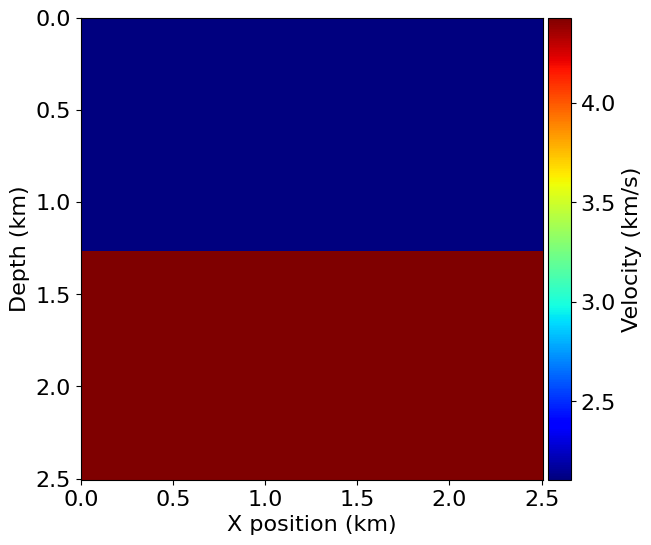

In [18]:
# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

In [19]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 2000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

Operator `Kernel` ran in 0.01 s


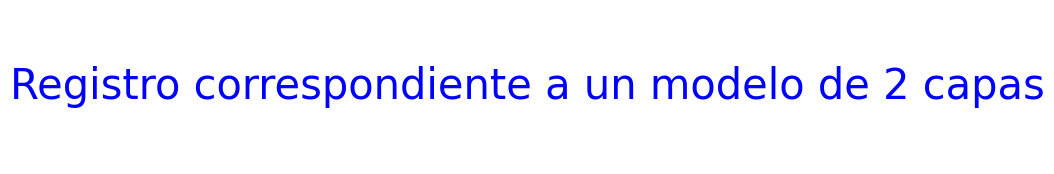

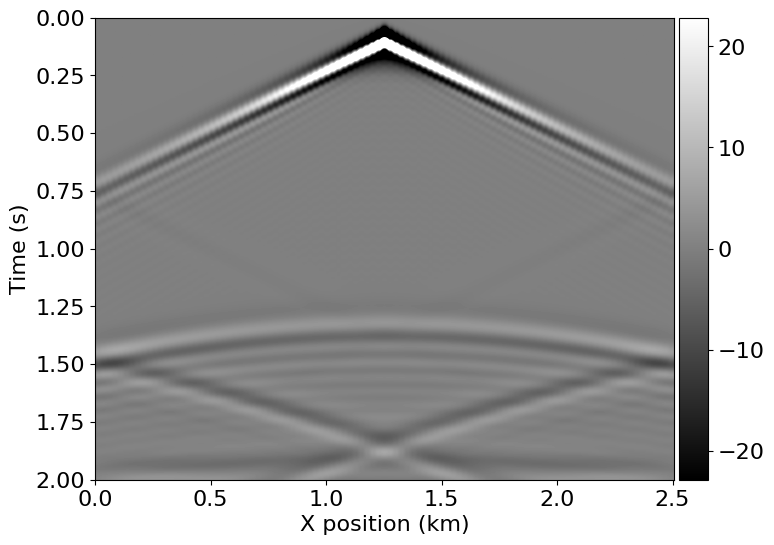

In [20]:
print_registro(model,2)

# Recurrencia

In [21]:

Vel_Pozo= pd.read_csv('vel_pozo_edit.csv')
depth_max=Vel_Pozo.DEPTH.max()
depth_max
shape = (101, 101)  # Number of grid point (nx, nz)
dz=depth_max/(shape[1]-1)
dz
# Define a physical size
dx=dz


spacing = (dx, dz)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers




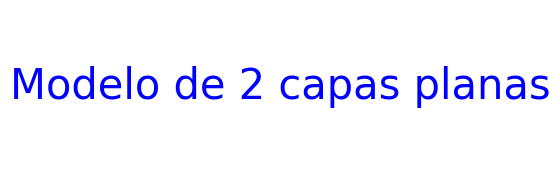

Operator `initdamp` ran in 0.01 s


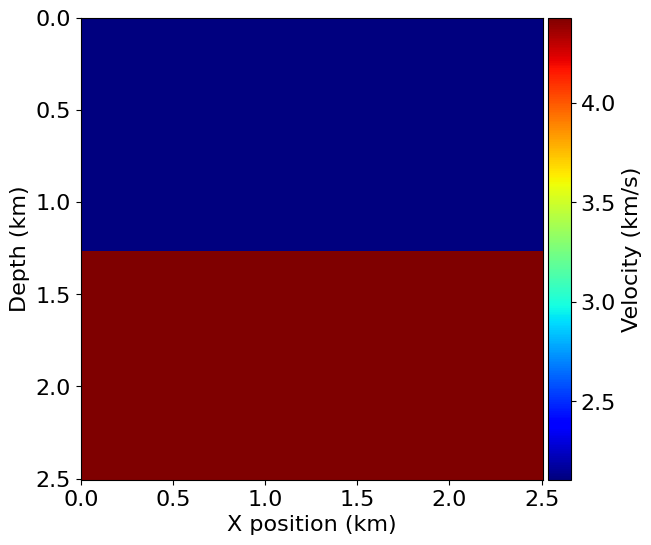

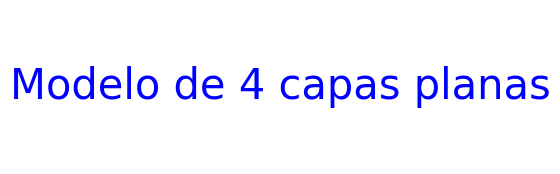

Operator `initdamp` ran in 0.01 s


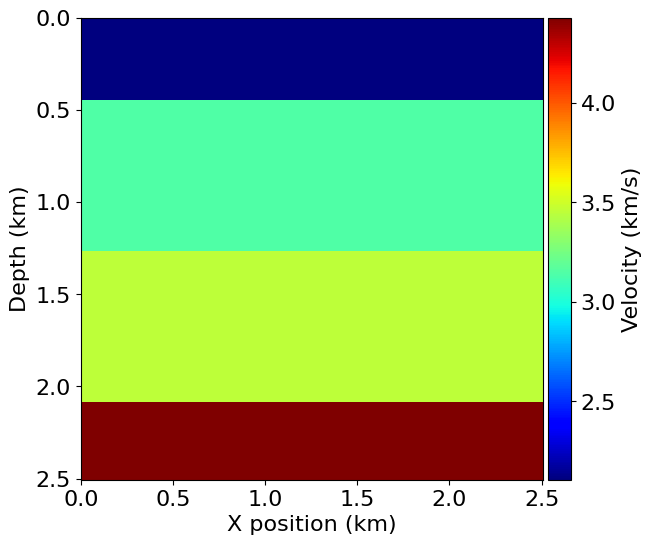

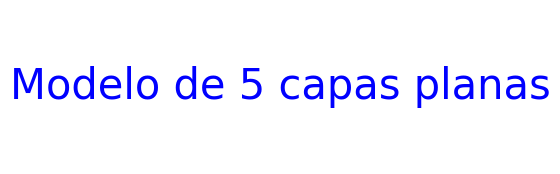

Operator `initdamp` ran in 0.01 s


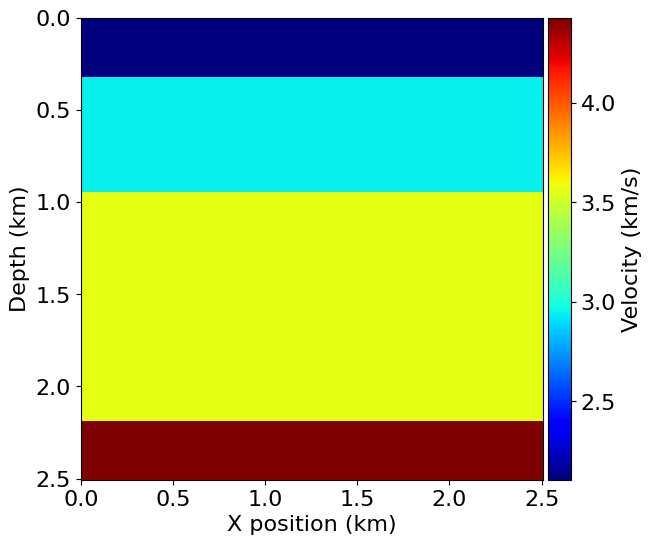

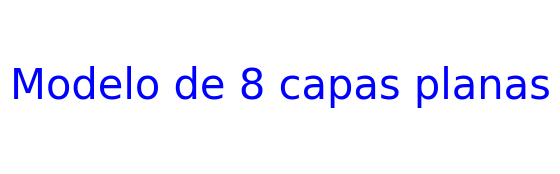

Operator `initdamp` ran in 0.01 s


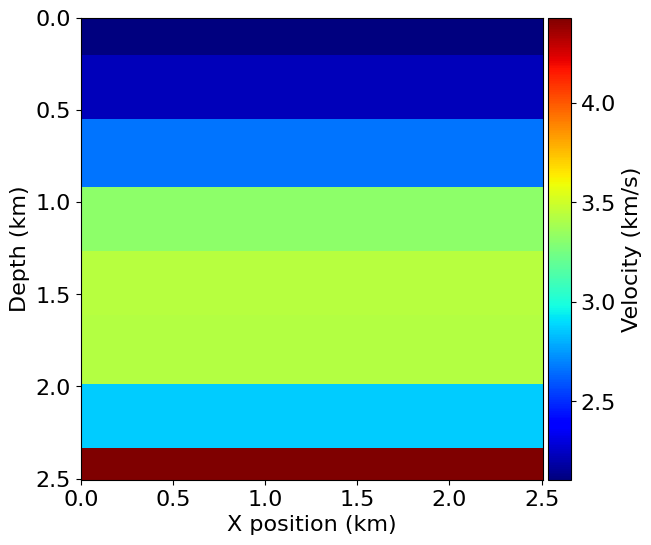

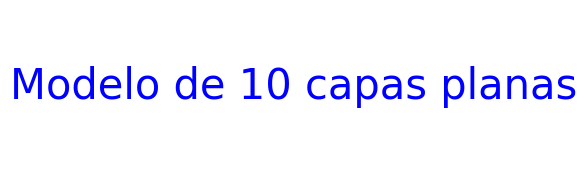

Operator `initdamp` ran in 0.01 s


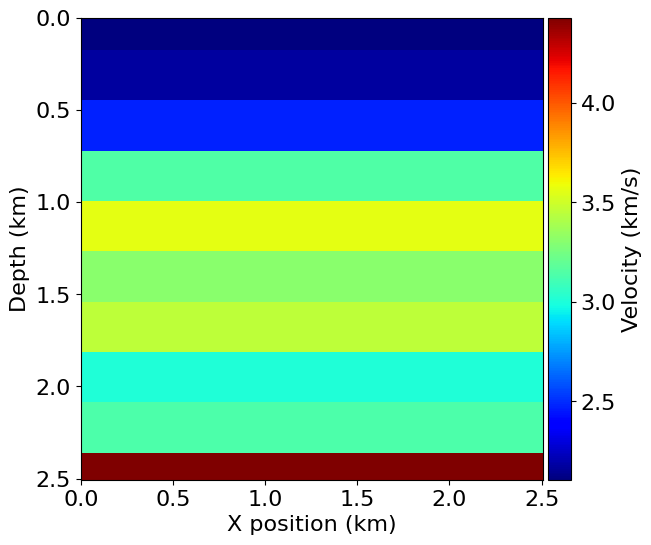

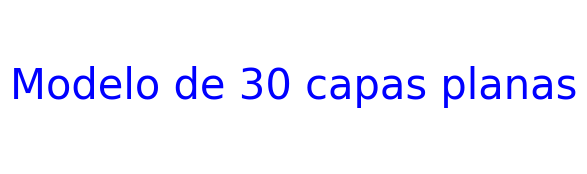

Operator `initdamp` ran in 0.01 s


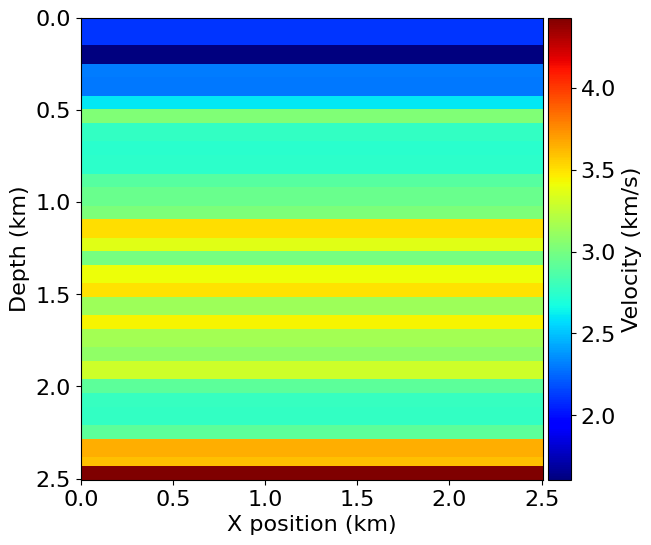

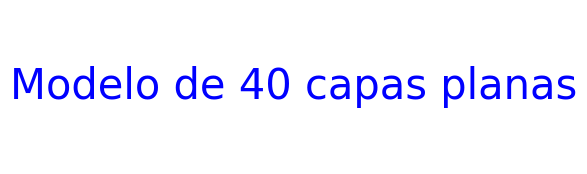

Operator `initdamp` ran in 0.01 s


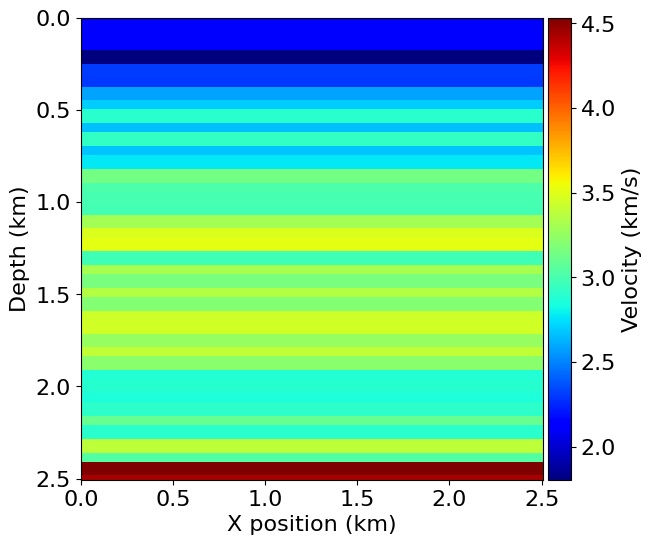

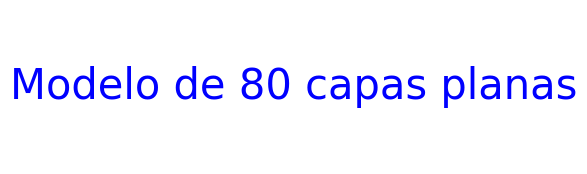

Operator `initdamp` ran in 0.01 s


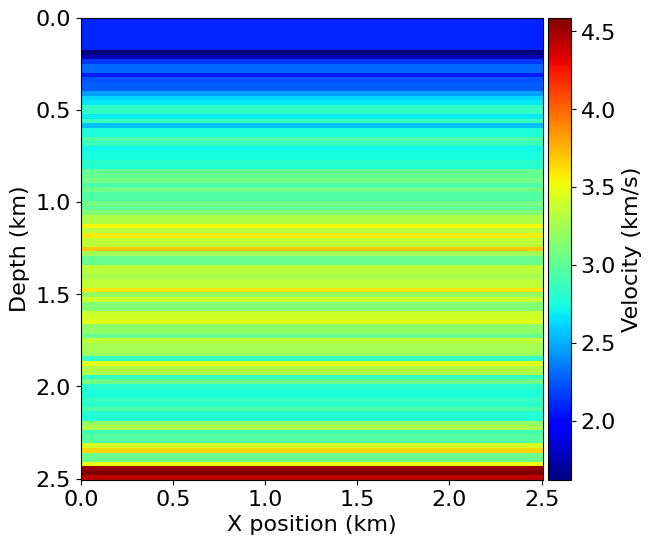

In [22]:
Muticapa=[2,4,5,8,10,30,40,80]
for ncapas in Muticapa:
    
    capas=capas_pre_devito(Vel_Pozo,ncapas,shape[1])
    
    v=v = campo_velocidades_devito(shape, capas)
    # With the velocity and model size defined, we can create the seismic model that
    # encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
    
    fig, ax = plt.subplots(figsize=(2, 2))  # Ajusta el tamaño de la figura aquí

    # Configurar el texto
    ax.text(0.5, 0.5, f'Modelo de {ncapas} capas planas', fontsize=30, ha='center', va='center', color='blue')

    # Configurar el estilo del gráfico
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Ocultar ejes

    # Mostrar el gráfico
    plt.show()
    
    
    
    
    
    model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
                space_order=2, nbl=10, bcs="damp")

    plot_velocity(model)

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


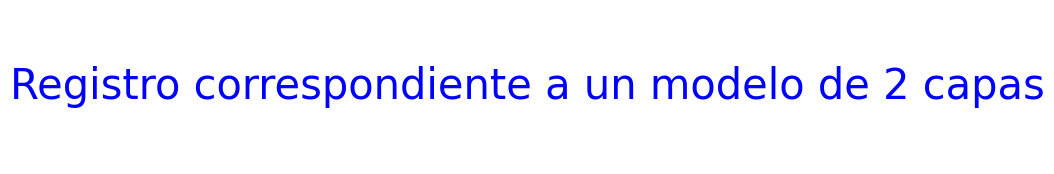

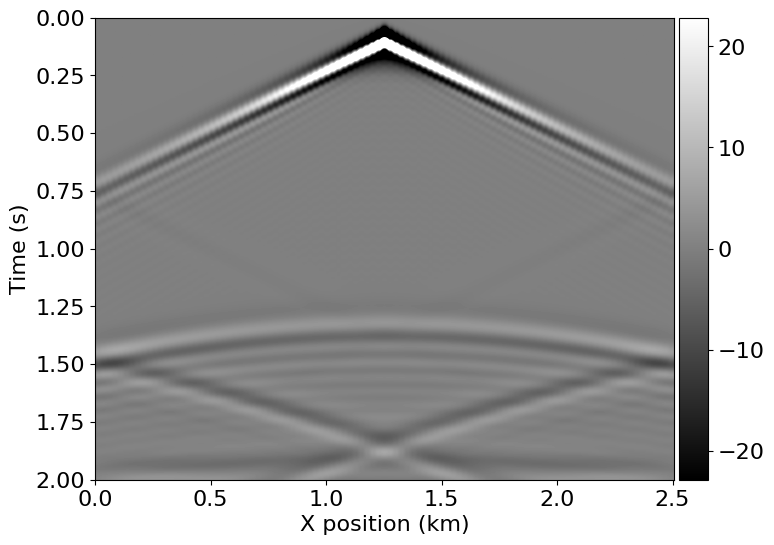

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


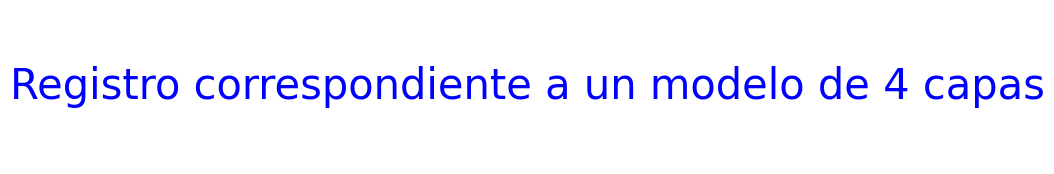

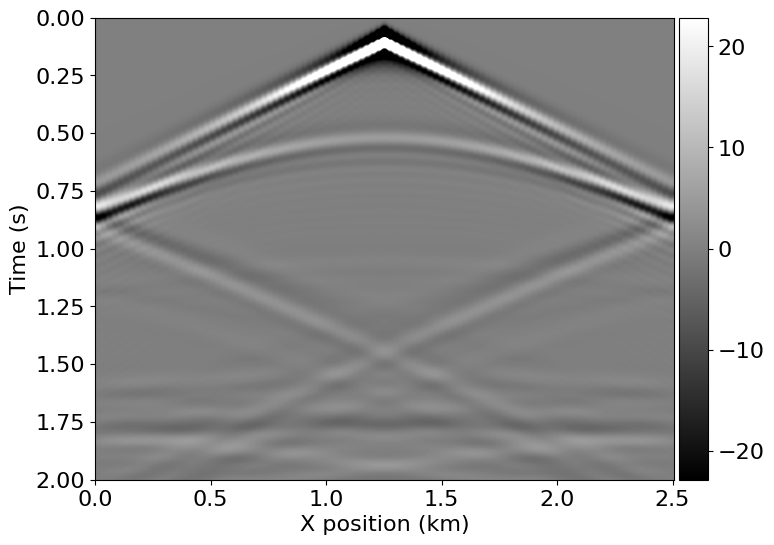

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


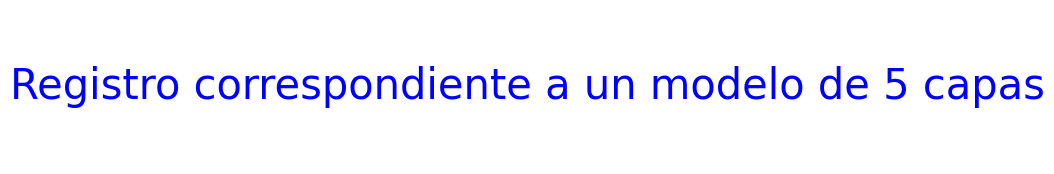

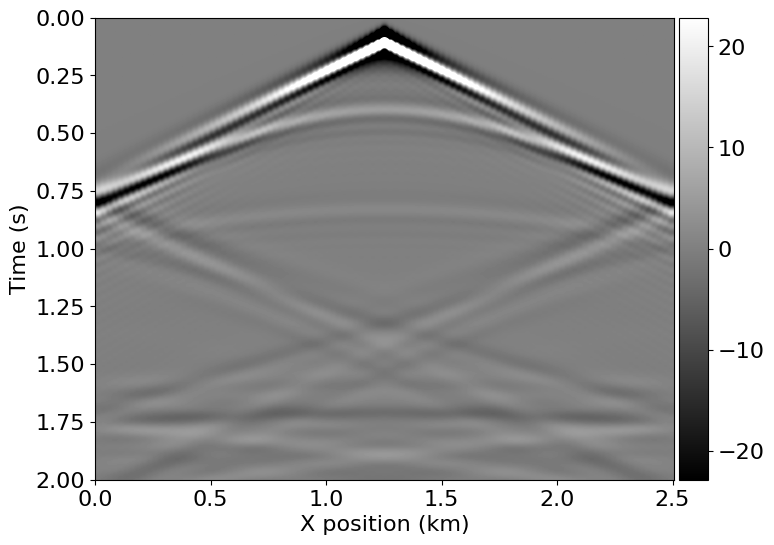

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


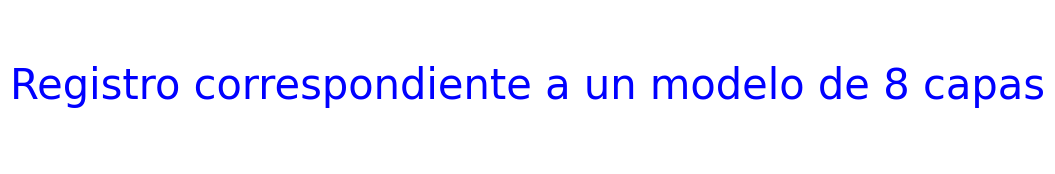

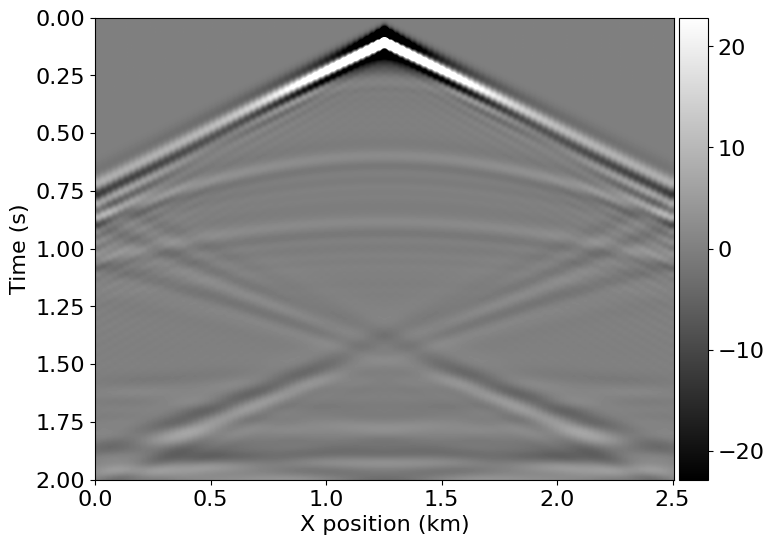

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


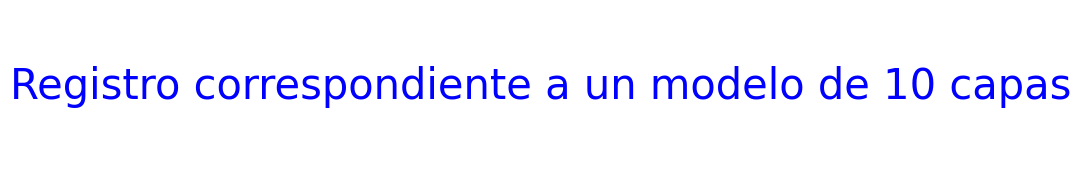

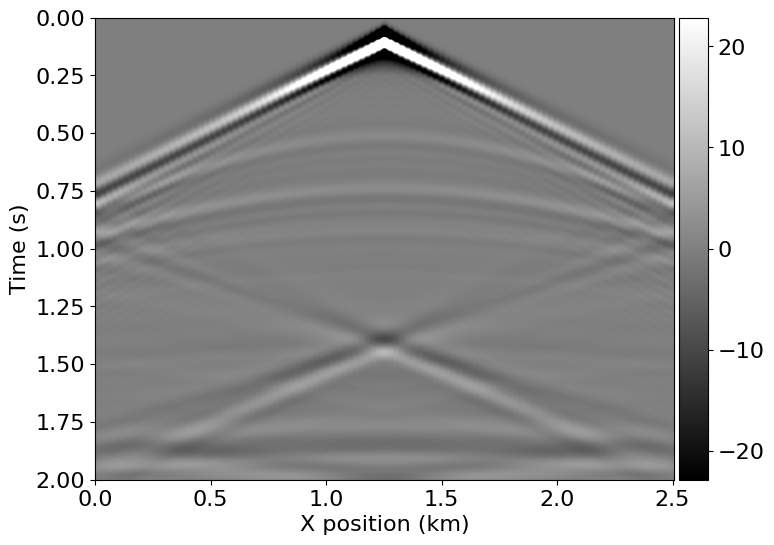

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


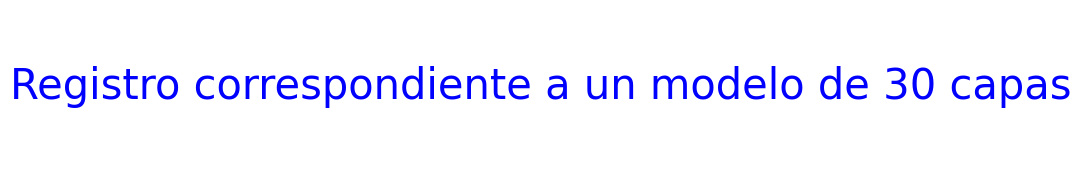

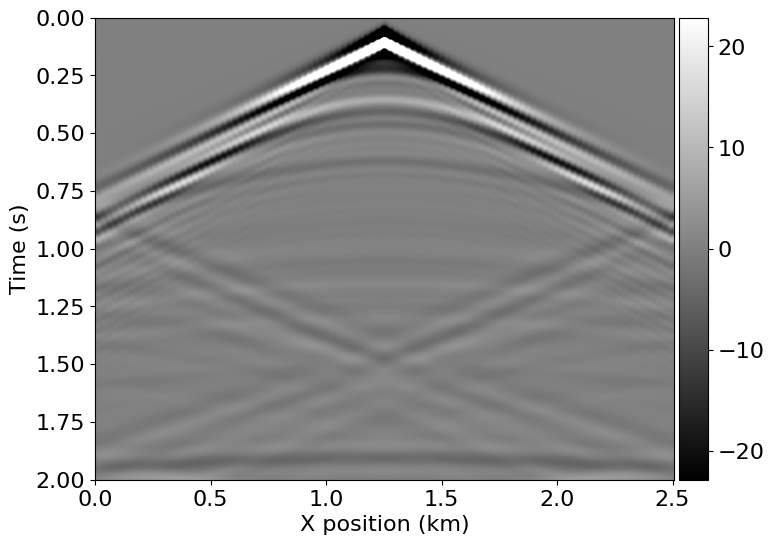

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


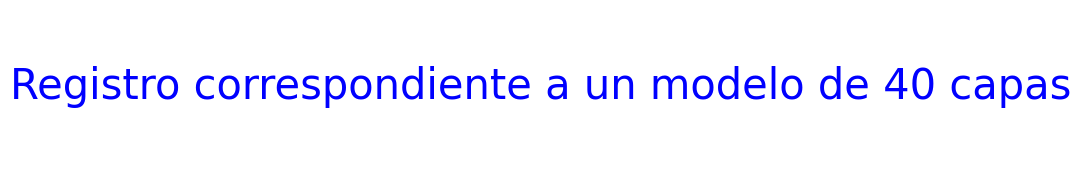

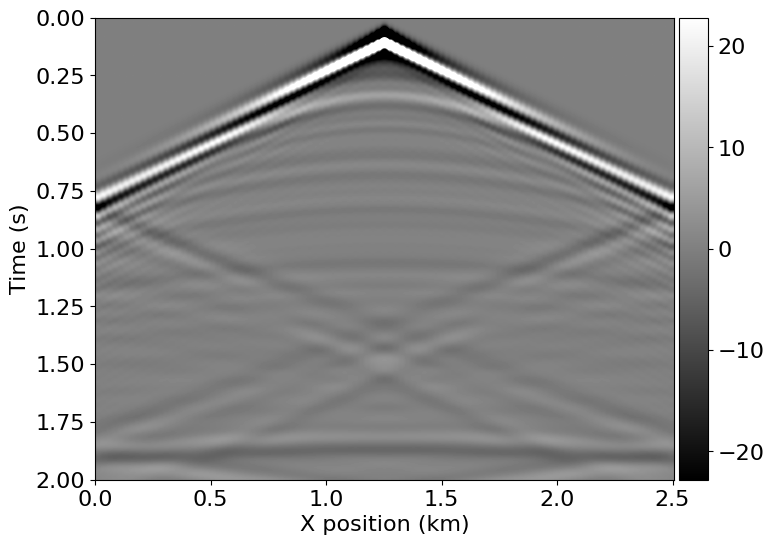

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


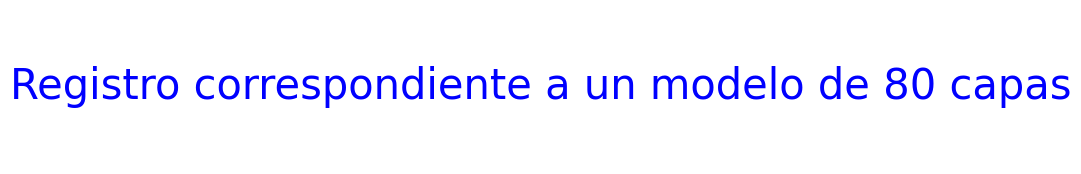

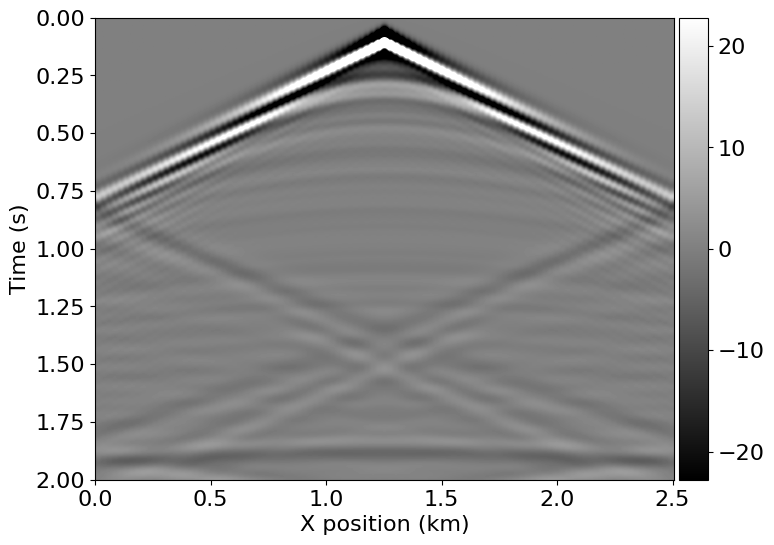

In [23]:


for ncapas in Muticapa:
    
    capas=capas_pre_devito(Vel_Pozo,ncapas,shape[1])
    
    v=v = campo_velocidades_devito(shape, capas)
    # With the velocity and model size defined, we can create the seismic model that
    # encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
    
     
    
    
    
    
    model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
                space_order=2, nbl=10, bcs="damp")



    from examples.seismic import TimeAxis

    t0 = 0.  # Simulation starts a t=0
    tn = 2000.  # Simulation last 1 second (1000 ms)
    dt = model.critical_dt  # Time step from model grid spacing

    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    print_registro(model,ncapas)